This notebook illustrates how a a retailer can use deep learning to generate new product descriptions for every page on their e-commerce platform and  wanted to observe whether this had worked or not. The work was delivered to the site on a single date and the traffic was trending upwards anyway, so a simple before-and-after test would 
show an improvement even if you’d done nothing.

By running this scenario through a causal impact model, we could make a prediction on, say, the number of 
organic search impressions generated, and make a prediction on what we would expect to see in the next period
if nothing was changed. Then you’d be able to assess whether the number of impressions fell significantly 
outside the forecast range, thus giving you a good indicator of whether the changes worked or not.

In [1]:
%matplotlib inline

import sys
import os
import warnings
import logging



logging.getLogger('tensorflow').setLevel(logging.FATAL)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings("ignore")
sys.path.append(os.path.abspath('../'))


import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from causalimpact import CausalImpact


tfd = tfp.distributions
plt.rcParams['figure.figsize'] = [15, 10]

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/flyandlure/datasets/master/causal_impact_dataset.csv')
df.head()

,date,clicks,impressions,ctr,position
0,2021-07-04,136,6301,2.16,31.97
1,2021-07-05,264,8697,3.04,27.66
2,2021-07-06,299,9236,3.24,26.38
3,2021-07-07,276,10008,2.76,26.77
4,2021-07-08,283,9725,2.91,25.83


In [3]:
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df.head()

,clicks,impressions,ctr,position
date,,,,
2021-07-04,136,6301,2.16,31.97
2021-07-05,264,8697,3.04,27.66
2021-07-06,299,9236,3.24,26.38
2021-07-07,276,10008,2.76,26.77
2021-07-08,283,9725,2.91,25.83


### Define the pre-period and post-period dates


Now we’ve got our data prepared, we need to define the pre_period and post_period dates, which need to be 
provided in list format. The pre_period list will contain two dates: the start date is the earliest date 
in the dataframe (2021-07-04), while the end date is the day before the site change was made. 
The post_period contains the date reflecting the day the change was made, plus the end date for this period.



In [4]:
pre_period = ['2021-07-04', '2021-07-17']
post_period = ['2021-07-18', '2021-07-31']

### Fit the CausalImpact model


All we need to do now is pass in the dataframe column containing the metric we want to examine, i.e. clicks 
and the pre_period and post_period lists containing the four dates. There are various other settings you can 
configure with CausalImpact, but we’ll just create a simple base model to keep things simple. 
As this dataset is very small, the model should fit in seconds, with the function returning an object called model 
that you can manipulate in a number of different ways.



In [5]:
model = CausalImpact(df['clicks'], pre_period, post_period)

Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`
Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


### Examine the model outputs


The above model predicted that in the absence of intervention we should expect to see an average of 243 clicks in 
the post-intervention period, but we actually generated 344.

By subtracting the actual number of clicks in the post-intervention period to what was predicted by the model 
in the absence of intervention, you get to see the causal effect of that the intervention probably had upon your response variable - the clicks. The site changes made increased clicks by nearly 42%, which was statistically significant and is unlikely to be random 
(but may, of course, have been caused by something els

In [6]:
print(model.summary(output='report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 344.36. By contrast, in the absence of an
intervention, we would have expected an average response of 242.44.
The 95% interval of this counterfactual prediction is [204.2, 279.78].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 101.92 with a 95% interval of
[64.58, 140.15]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 4821.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 3394.14. The 95% interval of this prediction is [2858.84, 3916.95].


The above results are given in terms of absolute numbers. In relative
terms, the respons

To see the actual statistics from the Causal Impact model, you can print the output of model.summary(). 
This shows you various data points mentioned in the verbose summary above, including the absolute and relative
effects, the prediction and the actual.



In [7]:
print(model.summary())


Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    344.36             4821.0
Prediction (s.d.)         242.44 (19.28)     3394.14 (269.93)
95% CI                    [204.2, 279.78]    [2858.84, 3916.95]

Absolute effect (s.d.)    101.92 (19.28)     1426.86 (269.93)
95% CI                    [64.58, 140.15]    [904.05, 1962.16]

Relative effect (s.d.)    42.04% (7.95%)     42.04% (7.95%)
95% CI                    [26.64%, 57.81%]   [26.64%, 57.81%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


If you want to observe the time series data in a plot, you can run model.plot(). 
This will show the whole time series and place a line on the chart indicating the start of 
the post-intervention period at which the site change was made. It will plot the predicted response 
variable - y - as well as the actual value recorded, and a confidence interval. It also shows the cumulative effect,
which in our case is positive, as the site change seemed to work rather well.



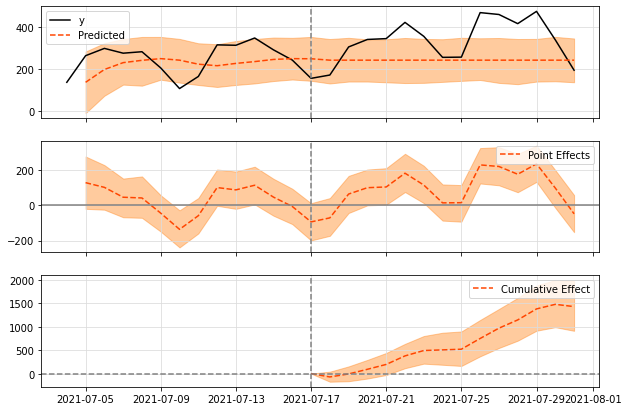

In [8]:
model.plot()


You can output the inferences dataframe. This gives you all the raw data, and the various predictions and actual data, should you wish to analyse them separately.



### Further reading


Brodersen, K.H., Gallusser, F., Koehler, J., Remy, N. and Scott, S.L., 2015. Inferring causal impact using Bayesian structural time-series models. The Annals of Applied Statistics, 9(1), pp.247-274.